# Detección de Fraudes en Reportes de Daños Vehiculares

Este proyecto desarrolla un modelo de inteligencia artificial diseñado para detectar fraudes en reportes de daños vehiculares. Utilizando técnicas avanzadas de análisis de datos y modelado, hemos implementado un sistema que identifica reportes fraudulentos con alta precisión.

# Importaciones

In [1]:
import pandas as pd
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
import shap
import category_encoders as ce

pd.set_option('display.max_columns', None)

c:\Users\Gis03\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#Carga de Datos y Limpieza

In [2]:
df = pd.read_csv('input/vehiculos_train.csv', parse_dates=['fecha_averia','fecha_reparacion'])
df

marca            modelo   color  anio_registro tipo_vehiculo  \
0                Jeep          Renegade   Black         2018.0           SUV   
1            Vauxhall          Insignia    Grey         2011.0     Hatchback   
2       Mercedes-Benz         GLC Class   White         2019.0           SUV   
3             Renault               NaN     NaN         2014.0     Hatchback   
4                Ford             C-Max     NaN         2007.0           MPV   
...               ...               ...     ...            ...           ...   
196424        Peugeot              3008   Black         2013.0           SUV   
196425       Infiniti               NaN   Black         2017.0        Saloon   
196426        Citroen  Grand C4 Picasso   White         2017.0           MPV   
196427     Volkswagen            Touran    Blue         2017.0           MPV   
196428           SEAT               Mii  Silver            NaN     Hatchback   

        millas_recorridas tamanio_motor transmision tipo_combustible  \
0                    17.0          1.4L      Manual           Petrol   
1                 93000.0           NaN      Manual           Petrol   
2                  6879.0          2.0L   Automatic           Diesel   
3                 20669.0          1.2L      Manual           Petrol   
4                 84786.0          1.6L      Manual           Petrol   
...                   ...           ...         ...              ...   
196424            83000.0          1.6L   Automatic           Diesel   
196425            19837.0          2.2L   Automatic           Diesel   
196426             9631.0          1.6L      Manual           Diesel   
196427            11513.0          2.0L   Automatic           Diesel   
196428            46000.0          1.0L      Manual           Petrol   

        precio_vehiculo  num_asientos  num_puertas         problema_averia  \
0               16000.0           5.0          5.0        Electrical Issue   
1                3995.0           5.0          5.0     Excessive Emissions   
2               31498.0           5.0          5.0        Windscreen Crack   
3                6950.0           5.0          5.0         Brake Pads Worn   
4                   NaN           5.0          5.0          Tyre Alignment   
...                 ...           ...          ...                     ...   
196424           5975.0           5.0          5.0         Brake Pads Worn   
196425          19799.0           5.0          4.0     Excessive Emissions   
196426          15000.0           5.0          5.0  Steering Wheel Shaking   
196427          21222.0           7.0          5.0        Electrical Issue   
196428           5000.0           4.0          5.0         Brake Pads Worn   

        id_problema_averia fecha_averia  complejidad_reparacion  \
0                        5   2018-06-07                       1   
1                        0   2018-08-09                       1   
2                        0   2021-06-17                       1   
3                        0   2018-04-23                       1   
4                        0   2018-05-20                       1   
...                    ...          ...                     ...   
196424                   0   2018-08-10                       1   
196425                   0   2018-03-15                       2   
196426                   0   2018-06-28                       2   
196427                   3   2018-07-12                       1   
196428                   0   2018-06-13                       2   

        costo_reparacion  horas_reparacion fecha_reparacion  fraude  
0                76.0000               3.0       2018-06-07       0  
1                23.5955               1.0       2018-08-09       0  
2                38.8988               1.0       2021-06-17       0  
3                43.4750               2.0       2018-04-23       0  
4                10.2600               0.5       2018-05-20       0  
...                  ...    

In [3]:
df.columns

Index(['marca', 'modelo', 'color', 'anio_registro', 'tipo_vehiculo',
       'millas_recorridas', 'tamanio_motor', 'transmision', 'tipo_combustible',
       'precio_vehiculo', 'num_asientos', 'num_puertas', 'problema_averia',
       'id_problema_averia', 'fecha_averia', 'complejidad_reparacion',
       'costo_reparacion', 'horas_reparacion', 'fecha_reparacion', 'fraude'],
      dtype='object')

In [4]:
print(df.isnull().sum())

marca                         0
modelo                    18661
color                      4848
anio_registro              4830
tipo_vehiculo                 0
millas_recorridas          2765
tamanio_motor               947
transmision                   0
tipo_combustible              0
precio_vehiculo            9562
num_asientos                  0
num_puertas                   0
problema_averia               0
id_problema_averia            0
fecha_averia                  0
complejidad_reparacion        0
costo_reparacion              0
horas_reparacion              0
fecha_reparacion              0
fraude                        0
dtype: int64


Todos estos datos deben de ser tratados ya sea con promedio o validaciones para obtener un prediccion correcta en el modelo

In [5]:
#Imputando los datos de mayor para los modelos de carros
frequent_models = df.groupby('marca')['modelo'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
model_mapping = frequent_models.to_dict()
df['modelo'].fillna(df['marca'].map(model_mapping), inplace=True)

C:\Users\Gis03\AppData\Local\Temp\ipykernel_6356\741650660.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['modelo'].fillna(df['marca'].map(model_mapping), inplace=True)


Se imputa el anio tomando en consideracion la marca, el modelo y el tipo de vehiculo

In [6]:
#Año de registro imputados
anio_mode_by_brand_model = df.groupby(['marca', 'modelo','tipo_vehiculo'])['anio_registro'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
anio_mode_mapping = anio_mode_by_brand_model.to_dict()
def impute_anio_registro(row):
    if pd.isnull(row['anio_registro']):
        key = (row['marca'], row['modelo'], row['tipo_vehiculo'])
        return anio_mode_mapping.get(key)
    else:
        return row['anio_registro']
df['anio_registro'] = df.apply(impute_anio_registro, axis=1)


Para las millas recorridas se considera el ano de registro y se la fecha de reparacion

In [7]:
def impute_millas_recorridas(row):
    if pd.isnull(row['millas_recorridas']):
        year_registered = row['anio_registro']
        repair_year = pd.to_datetime(row['fecha_reparacion']).year
        mean_miles = mean_miles_mapping.get(year_registered, df['millas_recorridas'].mean())
        if np.isnan(mean_miles):
            return -1
        else:
            return mean_miles * (repair_year - year_registered + 1)
    else:
        return row['millas_recorridas']

mean_miles_by_year = df.groupby('anio_registro')['millas_recorridas'].mean()
mean_miles_mapping = mean_miles_by_year.to_dict()
df['millas_recorridas'] = df.apply(impute_millas_recorridas, axis=1)

por ultimo el precio y tamanio de motor dependen de la marca y modelo del vehiculo

In [8]:
def impute_precio_vehiculo(row):
    if pd.isnull(row['precio_vehiculo']):
        brand = row['marca']
        model = row['modelo']
        mean_price = mean_price_mapping.get((brand, model, row['tipo_vehiculo'],row['anio_registro']), df['precio_vehiculo'].mean())
        return mean_price
    else:
        return row['precio_vehiculo']

mean_price_by_model_brand = df.groupby(['marca', 'modelo', 'tipo_vehiculo', 'anio_registro'])['precio_vehiculo'].mean()
mean_price_mapping = mean_price_by_model_brand.to_dict()
df['precio_vehiculo'] = df.apply(impute_precio_vehiculo, axis=1)

In [9]:
def impute_tamanio_motor(row):
    if pd.isnull(row['tamanio_motor']):
        brand = row['marca']
        model = row['modelo']
        mode_motor_size = motor_size_mode_mapping.get((brand, model,row['tipo_vehiculo']))
        return mode_motor_size
    else:
        return row['tamanio_motor']

motor_size_mode_by_brand_model_type = df.groupby(['marca', 'modelo','tipo_vehiculo'])['tamanio_motor'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
motor_size_mode_mapping = motor_size_mode_by_brand_model_type.to_dict()
df['tamanio_motor'] = df.apply(impute_tamanio_motor, axis=1)

El color solo se imputa con la moda de los valores

In [10]:
df["color"].fillna(df["color"].mode()[0], inplace=True)

C:\Users\Gis03\AppData\Local\Temp\ipykernel_6356\2929076887.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["color"].fillna(df["color"].mode()[0], inplace=True)


In [11]:
# revisamos diferencias en fehcas de averia y reparacion con respecto al registro
df["diff_registro"] = df["fecha_averia"].dt.year - df["anio_registro"]
df["Espera_reparacion"] = (df["fecha_reparacion"] - df["fecha_averia"]).dt.days
df["Espera_reparacion"] = df["Espera_reparacion"].astype(int)

In [12]:
df["Clasificacion_espera"] = np.where(df["Espera_reparacion"]<0,2,0)
df["Clasificacion_espera"] = np.where(df["Espera_reparacion"]>15,1,df["Clasificacion_espera"])

In [13]:
### Para casos del año de registro vacio (se coloca a todos 0) Pero luego se discretiza la columna
df["diff_registro"] = df["diff_registro"].fillna(0)
df["Clasificacion_registro"] = np.where(df["diff_registro"]<0,2,0)
df["Clasificacion_registro"] = np.where(df["diff_registro"]>30,1,df["Clasificacion_registro"])
df["Clasificacion_registro"] = np.where(df["diff_registro"]==0,3,df["Clasificacion_registro"])

In [14]:
df["costo/complejidad"] = df["costo_reparacion"] / df["complejidad_reparacion"]

In [15]:
df["costo/complejidad"].describe()

count    196429.000000
mean        258.718696
std         673.160105
min       -2989.000000
25%          27.650000
50%          82.475000
75%         237.500000
max       32896.705443
Name: costo/complejidad, dtype: float64

In [16]:
df["fraude"].value_counts()

fraude
0    190352
1      6077
Name: count, dtype: int64

In [17]:
df[df["costo/complejidad"]<0]["fraude"].value_counts()

fraude
1    142
Name: count, dtype: int64

In [18]:
df_no_fraude_problema = df[df.fraude == 0].groupby('problema_averia')['costo_reparacion'].agg(['mean','max','std']).reset_index()

In [19]:
def calcular_costo_rep(df, df_no_fraude_problema):
    nuevo= {}
    for i in df["problema_averia"].unique():
        df_1 = df[df["problema_averia"] == i]
        media = df_no_fraude_problema.loc[df_no_fraude_problema.problema_averia == i, 'mean'].max()
        std = df_no_fraude_problema.loc[df_no_fraude_problema.problema_averia == i, 'std'].max()
        df_1 = df_1.copy()
        df_1["Costo_Problema"] = (df_1.costo_reparacion - media) / std
        nuevo[i] = df_1
    df = pd.concat(nuevo.values())
    return df

df = calcular_costo_rep(df,df_no_fraude_problema)

In [20]:
df_horas_complejo = df[df.fraude == 0].groupby('complejidad_reparacion')['horas_reparacion'].agg(['mean','max','std']).reset_index()

In [21]:
def calcular_complejidad_hora(df, df_horas_complejo):
    nuevo= {}
    for i in df["complejidad_reparacion"].unique():
        df = df.copy()
        df_1 = df[df["complejidad_reparacion"] == i]
        media = df_horas_complejo.loc[df_horas_complejo.complejidad_reparacion == i, 'mean'].max()
        std = df_horas_complejo.loc[df_horas_complejo.complejidad_reparacion == i, 'std'].max()
        df_1 = df_1.copy()
        df_1["Horas_complejidad"] = (df_1.horas_reparacion - media) / std
        nuevo[i] = df_1
    df = pd.concat(nuevo.values())
    return df
df = calcular_complejidad_hora(df,df_horas_complejo)

Siendo para los casos de fraude el costo de reparacion se tienen en valores dobles de la media o menores a la media. se considera utilizar como metrica cuanto se desvia el valor con respecto a la media del valor que no es fraude.

In [22]:
df["Porc_reparacion"] = df["costo_reparacion"]/ df["precio_vehiculo"].abs()
df["Porc_reparacion"] = df["Porc_reparacion"].fillna(df["Porc_reparacion"].mean())

In [23]:
df_cleaned = df.dropna()

In [24]:
print(df_cleaned.isnull().sum())

marca                     0
modelo                    0
color                     0
anio_registro             0
tipo_vehiculo             0
millas_recorridas         0
tamanio_motor             0
transmision               0
tipo_combustible          0
precio_vehiculo           0
num_asientos              0
num_puertas               0
problema_averia           0
id_problema_averia        0
fecha_averia              0
complejidad_reparacion    0
costo_reparacion          0
horas_reparacion          0
fecha_reparacion          0
fraude                    0
diff_registro             0
Espera_reparacion         0
Clasificacion_espera      0
Clasificacion_registro    0
costo/complejidad         0
Costo_Problema            0
Horas_complejidad         0
Porc_reparacion           0
dtype: int64


El conjunto de datos contiene varias características. Después de la limpieza, el DataFrame df_cleaned tiene múltiples columnas que incluyen características numéricas y categóricas. Antes de la limpieza, había información sobre fechas y variables que fueron imputadas para asegurar que no faltaran datos.

# Seleccion de las variables a usar

In [25]:
df_cleaned.columns

Index(['marca', 'modelo', 'color', 'anio_registro', 'tipo_vehiculo',
       'millas_recorridas', 'tamanio_motor', 'transmision', 'tipo_combustible',
       'precio_vehiculo', 'num_asientos', 'num_puertas', 'problema_averia',
       'id_problema_averia', 'fecha_averia', 'complejidad_reparacion',
       'costo_reparacion', 'horas_reparacion', 'fecha_reparacion', 'fraude',
       'diff_registro', 'Espera_reparacion', 'Clasificacion_espera',
       'Clasificacion_registro', 'costo/complejidad', 'Costo_Problema',
       'Horas_complejidad', 'Porc_reparacion'],
      dtype='object')

In [26]:
asientos_max = df_cleaned[df_cleaned["fraude"]==0].groupby(['tipo_vehiculo'])['num_asientos'].agg(['max']).reset_index()
def getFraudeByAS(df,asientos_max):
    diccionario = {}
    for i in df["tipo_vehiculo"].unique():
        if i not in asientos_max['tipo_vehiculo'].unique():
            df_1 = df[df["tipo_vehiculo"] == i]
            df_1 = df_1.copy()
            df_1["num_asientos_grande"] = df_1["num_asientos"] > 9
        else:
            df_1 = df[df["tipo_vehiculo"] == i]
            numero = asientos_max.loc[asientos_max["tipo_vehiculo"] == i, 'max'].max()
            df_1 = df_1.copy()
            df_1["num_asientos_grande"] = df_1["num_asientos"] > numero
        diccionario[i] = df_1
    df = pd.concat(diccionario.values())
    return df
df_cleaned = getFraudeByAS(df_cleaned,asientos_max)

In [27]:
### Añadir los numeros de asientos/tamaño de motor
df_cleaned = df_cleaned[["precio_vehiculo","costo_reparacion","horas_reparacion","color",'tipo_vehiculo', 'tipo_combustible', "transmision",'millas_recorridas',"num_asientos","num_puertas",'id_problema_averia','diff_registro', 'Espera_reparacion', "Porc_reparacion",'costo/complejidad',
                         'Costo_Problema', 'Horas_complejidad','fraude']]

In [28]:
df_cleaned.head()

precio_vehiculo  costo_reparacion  horas_reparacion   color  \
0            16000.0            76.000               3.0   Black   
118           8200.0            68.200               3.0  Silver   
130          22500.0           132.500               1.0     Red   
141           6990.0            66.990               3.0    Grey   
145          38989.0           156.967               2.0    Grey   

    tipo_vehiculo tipo_combustible transmision  millas_recorridas  \
0             SUV           Petrol      Manual               17.0   
118           SUV           Diesel      Manual            91580.0   
130           SUV           Petrol      Manual             4000.0   
141           SUV           Petrol      Manual            78207.0   
145           SUV           Diesel   Automatic             7588.0   

     num_asientos  num_puertas  id_problema_averia  diff_registro  \
0             5.0          5.0                   5            0.0   
118           5.0          5.0                   5            8.0   
130           5.0          5.0                   3            0.0   
141           5.0          5.0                   5            8.0   
145           5.0          5.0                   4            1.0   

     Espera_reparacion  Porc_reparacion  costo/complejidad  Costo_Problema  \
0                    0         0.004750             76.000       -0.050408   
118                  0         0.008317             68.200       -0.166212   
130                  0         0.005889            132.500        0.788432   
141                  0         0.009584             66.990       -0.184177   
145                  0         0.004026            156.967        1.151687   

     Horas_complejidad  fraude  
0            -0.015485       0  
118          -0.015485       0  
130          -0.638442       0  
141          -0.015485       0  
145          -0.326964       0

In [29]:
df_cleaned = df_cleaned.reset_index(drop=True)

# Analisis Univariado

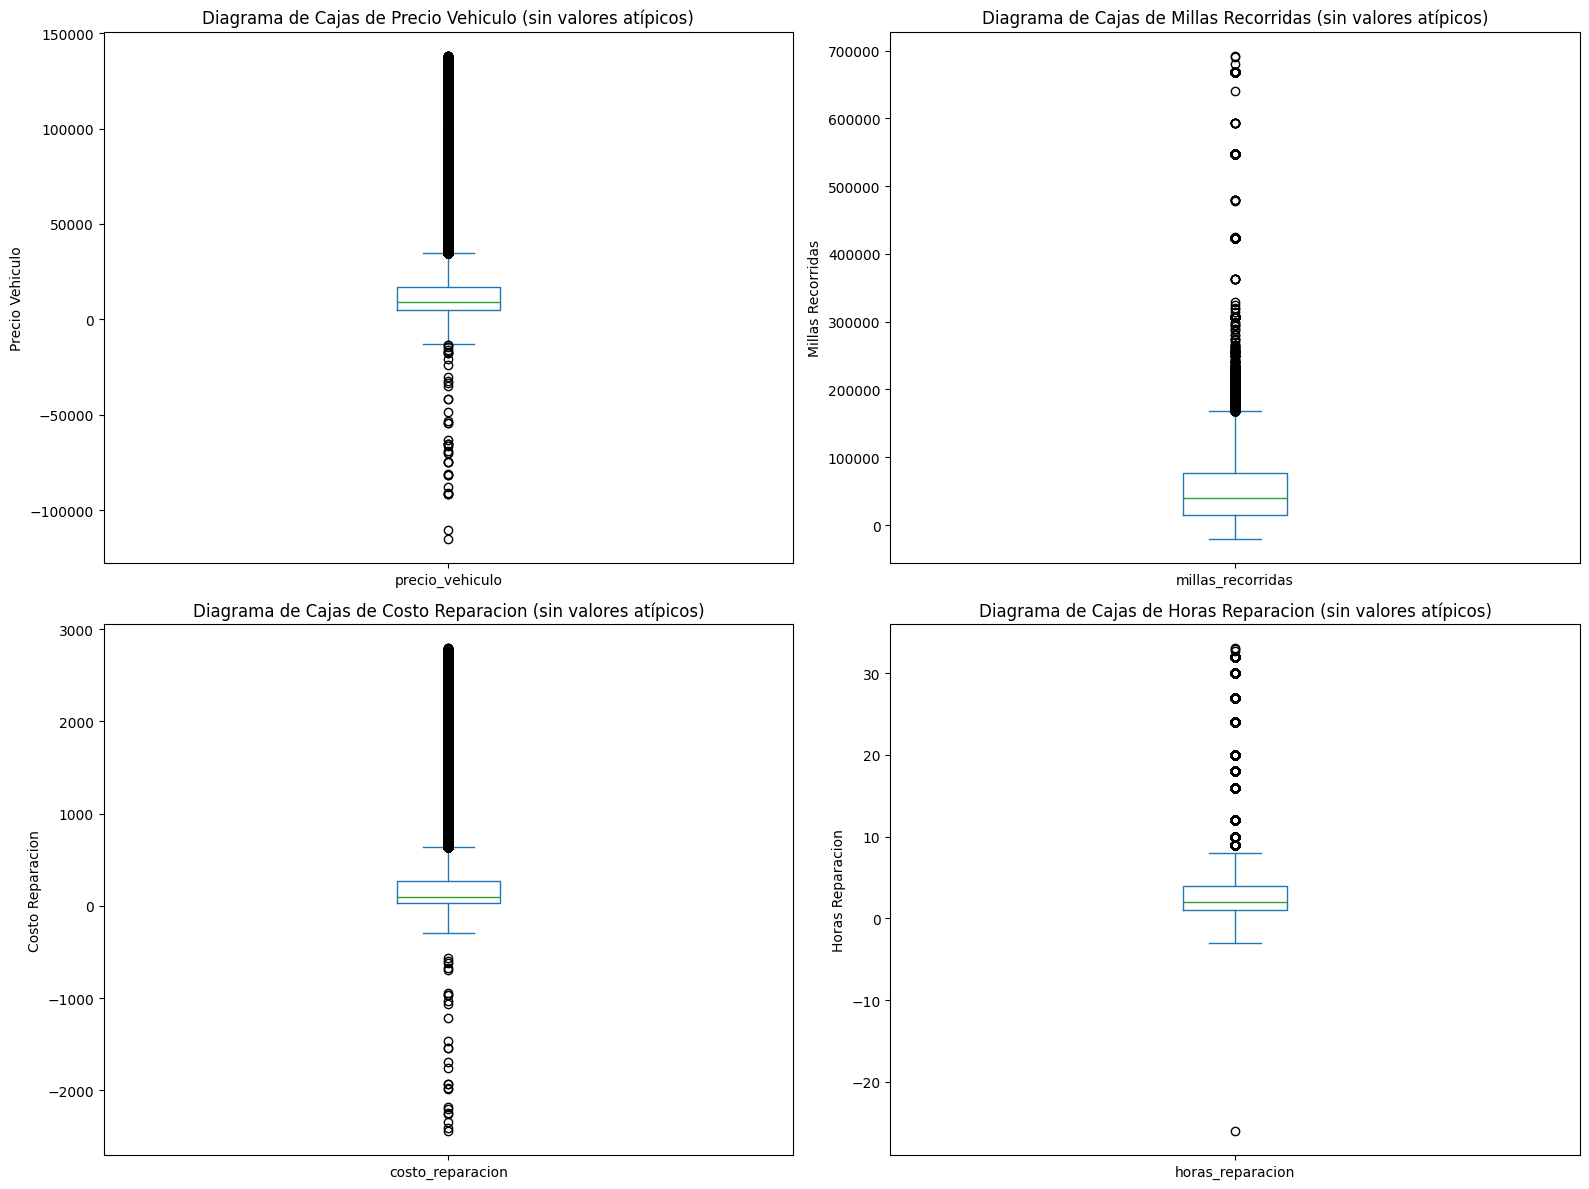

In [30]:
# Función para eliminar valores atípicos y devolver los outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 10 * IQR
    upper_bound = Q3 + 10 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    outliers_df = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return filtered_df, outliers_df

# Columnas a procesar
numeric_columns = ['precio_vehiculo', 'millas_recorridas', 'costo_reparacion', 'horas_reparacion']

# Crear diagramas de cajas sin valores atípicos
plt.figure(figsize=(16, 12))

outliers_combined = {}

df_filtered = df_cleaned.copy()

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    df_filtered, outliers = remove_outliers(df_filtered, column)
    df_filtered[column].plot(kind='box')
    plt.title(f'Diagrama de Cajas de {column.replace("_", " ").title()} (sin valores atípicos)')
    plt.ylabel(column.replace("_", " ").title())
    outliers_combined[column] = outliers[column]

plt.tight_layout()
plt.show()

*  Los diagramas de bigotes muestran que existen varios fuera de su rango intercuartil, sin embargo la gran concentracion de valores se encuentra dentro de este margen.
*   En cuanto a los valores a tipicos se eliminaron los extremos de cada uno de ellos realizando una remocion de outliers.



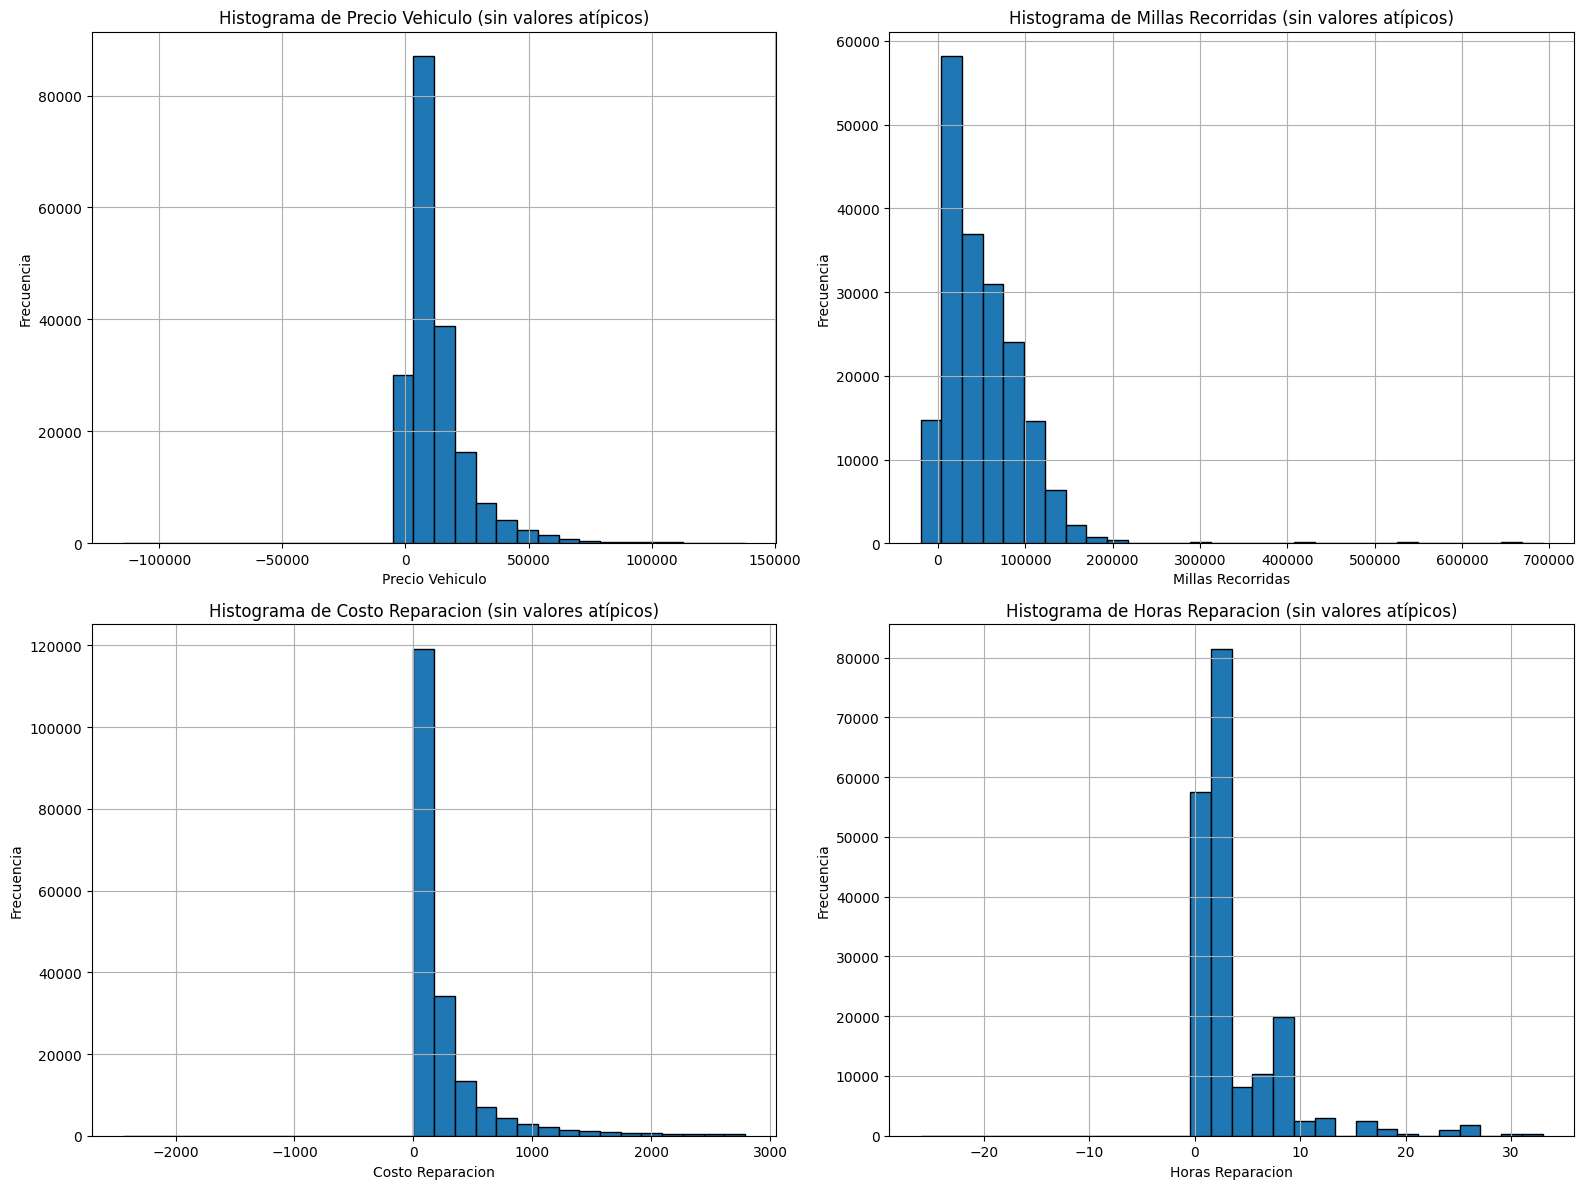

In [31]:
# Creando Histogramas
plt.figure(figsize=(16, 12))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    df_filtered[column].hist(bins=30, edgecolor='black')
    plt.title(f'Histograma de {column.replace("_", " ").title()} (sin valores atípicos)')
    plt.xlabel(column.replace("_", " ").title())
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()



*   En las graficas se aprecia que dichas variables presentan sesgo positivos o sesgo hacia la derecha.
*   Las graficas muestran que los costos de repacion en su mayoria estan por debajo de los $1000.
*   Las horas de reparacion en su mayoria no superan las 10 horas.
*   La mayor parte de los vehiculos esta por debajo de los 100 mil millas.
*   El precio de los vehiculo en su mayoria no supera los 50 mil dolares.



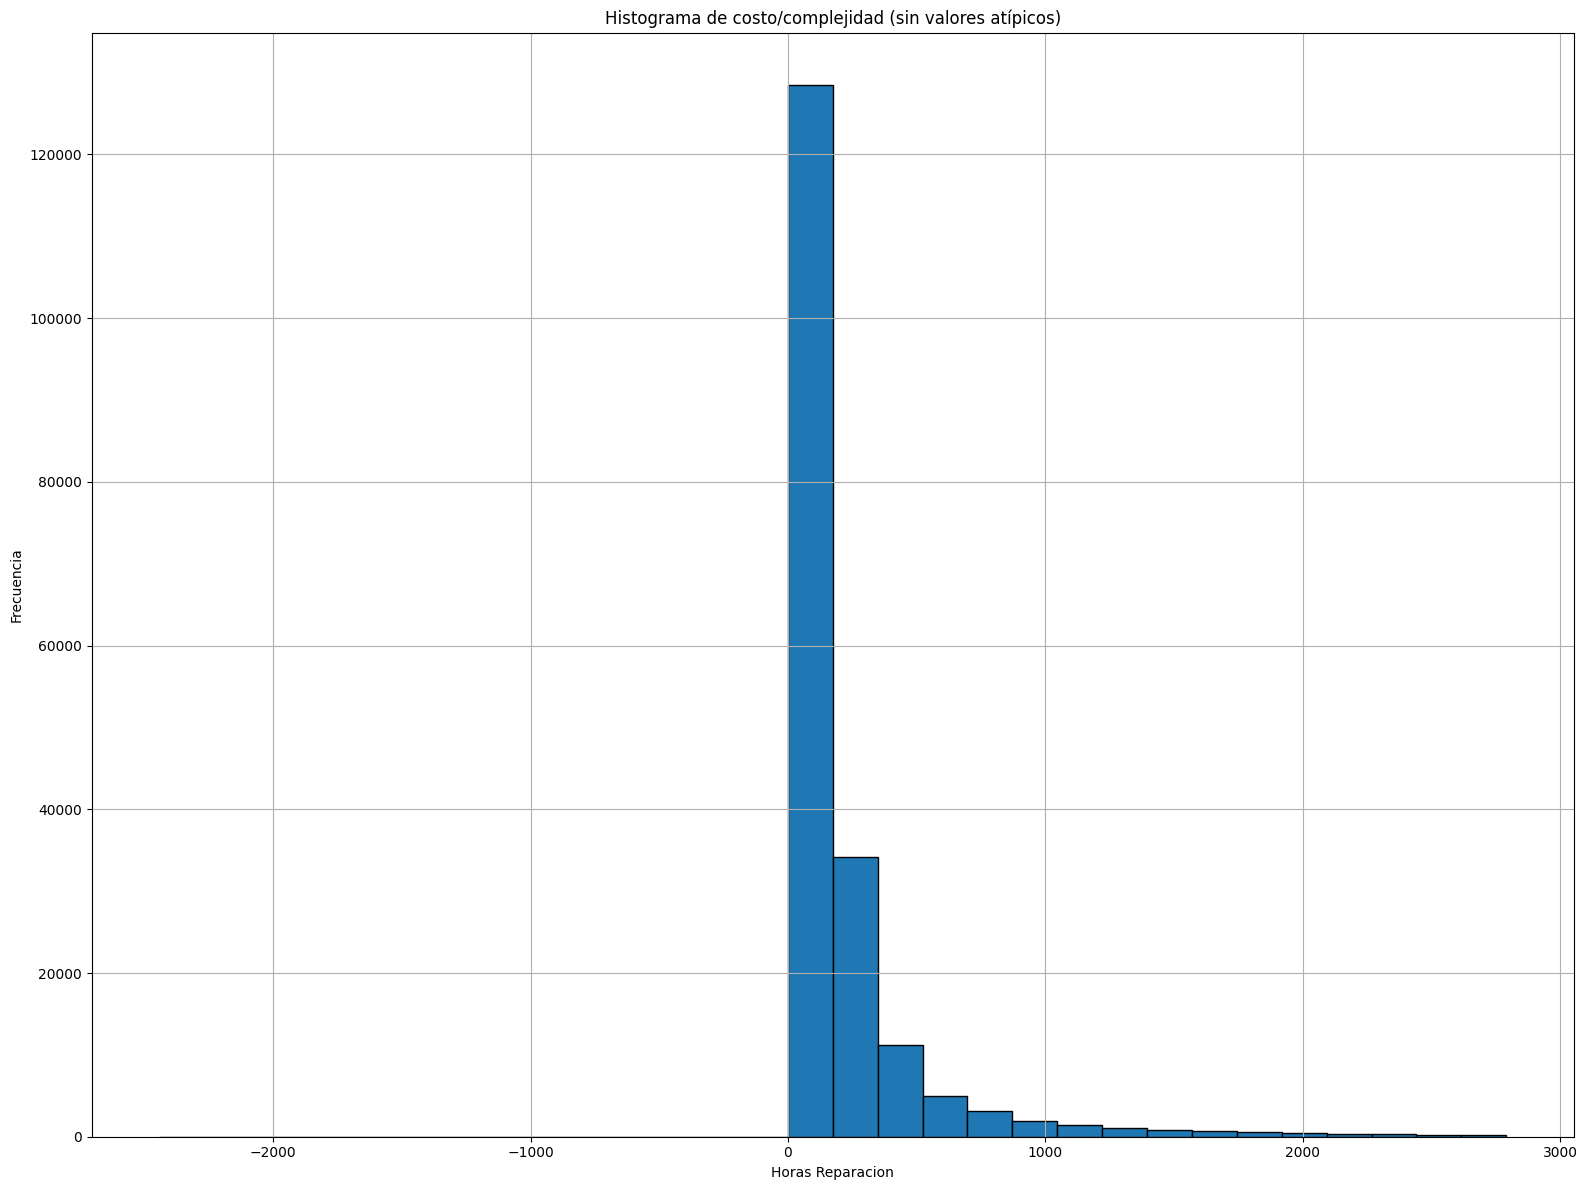

In [32]:
# Creando Histogramas
plt.figure(figsize=(16, 12))
df_filtered['costo/complejidad'].hist(bins=30, edgecolor='black')
plt.title('Histograma de costo/complejidad (sin valores atípicos)')
plt.xlabel(column.replace("_", " ").title())
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [33]:
for col in numeric_columns:
    print(f'Análisis univariado para {col}:')
    print(f'Media: {df_filtered[col].mean()}')
    print(f'Mediana: {df_filtered[col].median()}')
    print(f'Moda: {df_filtered[col].mode()}')
    print(f'Rango: {df_filtered[col].max() - df_filtered[col].min()}')
    print(f'Varianza: {df_filtered[col].var()}')
    print(f'Desviación estándar: {df_filtered[col].std()}')
    print()

Análisis univariado para precio_vehiculo:
Media: 12980.762556377036
Mediana: 8995.0
Moda: 0    3995.0
Name: precio_vehiculo, dtype: float64
Rango: 252734.0
Varianza: 185965742.87593013
Desviación estándar: 13636.925712048524

Análisis univariado para millas_recorridas:
Media: 50990.40255186521
Mediana: 41077.0
Moda: 0    10.0
Name: millas_recorridas, dtype: float64
Rango: 712126.1381875328
Varianza: 2325638268.685677
Desviación estándar: 48224.87188874302

Análisis univariado para costo_reparacion:
Media: 241.31813483293175
Mediana: 99.7
Moda: 0    199.9
Name: costo_reparacion, dtype: float64
Rango: 5232.0
Varianza: 143280.40372016074
Desviación estándar: 378.52398037662124

Análisis univariado para horas_reparacion:
Media: 3.84711427835325
Mediana: 2.0
Moda: 0    2.0
Name: horas_reparacion, dtype: float64
Rango: 59.009102907418345
Varianza: 20.708853743084102
Desviación estándar: 4.550698159962282



# Analisis Multivariado

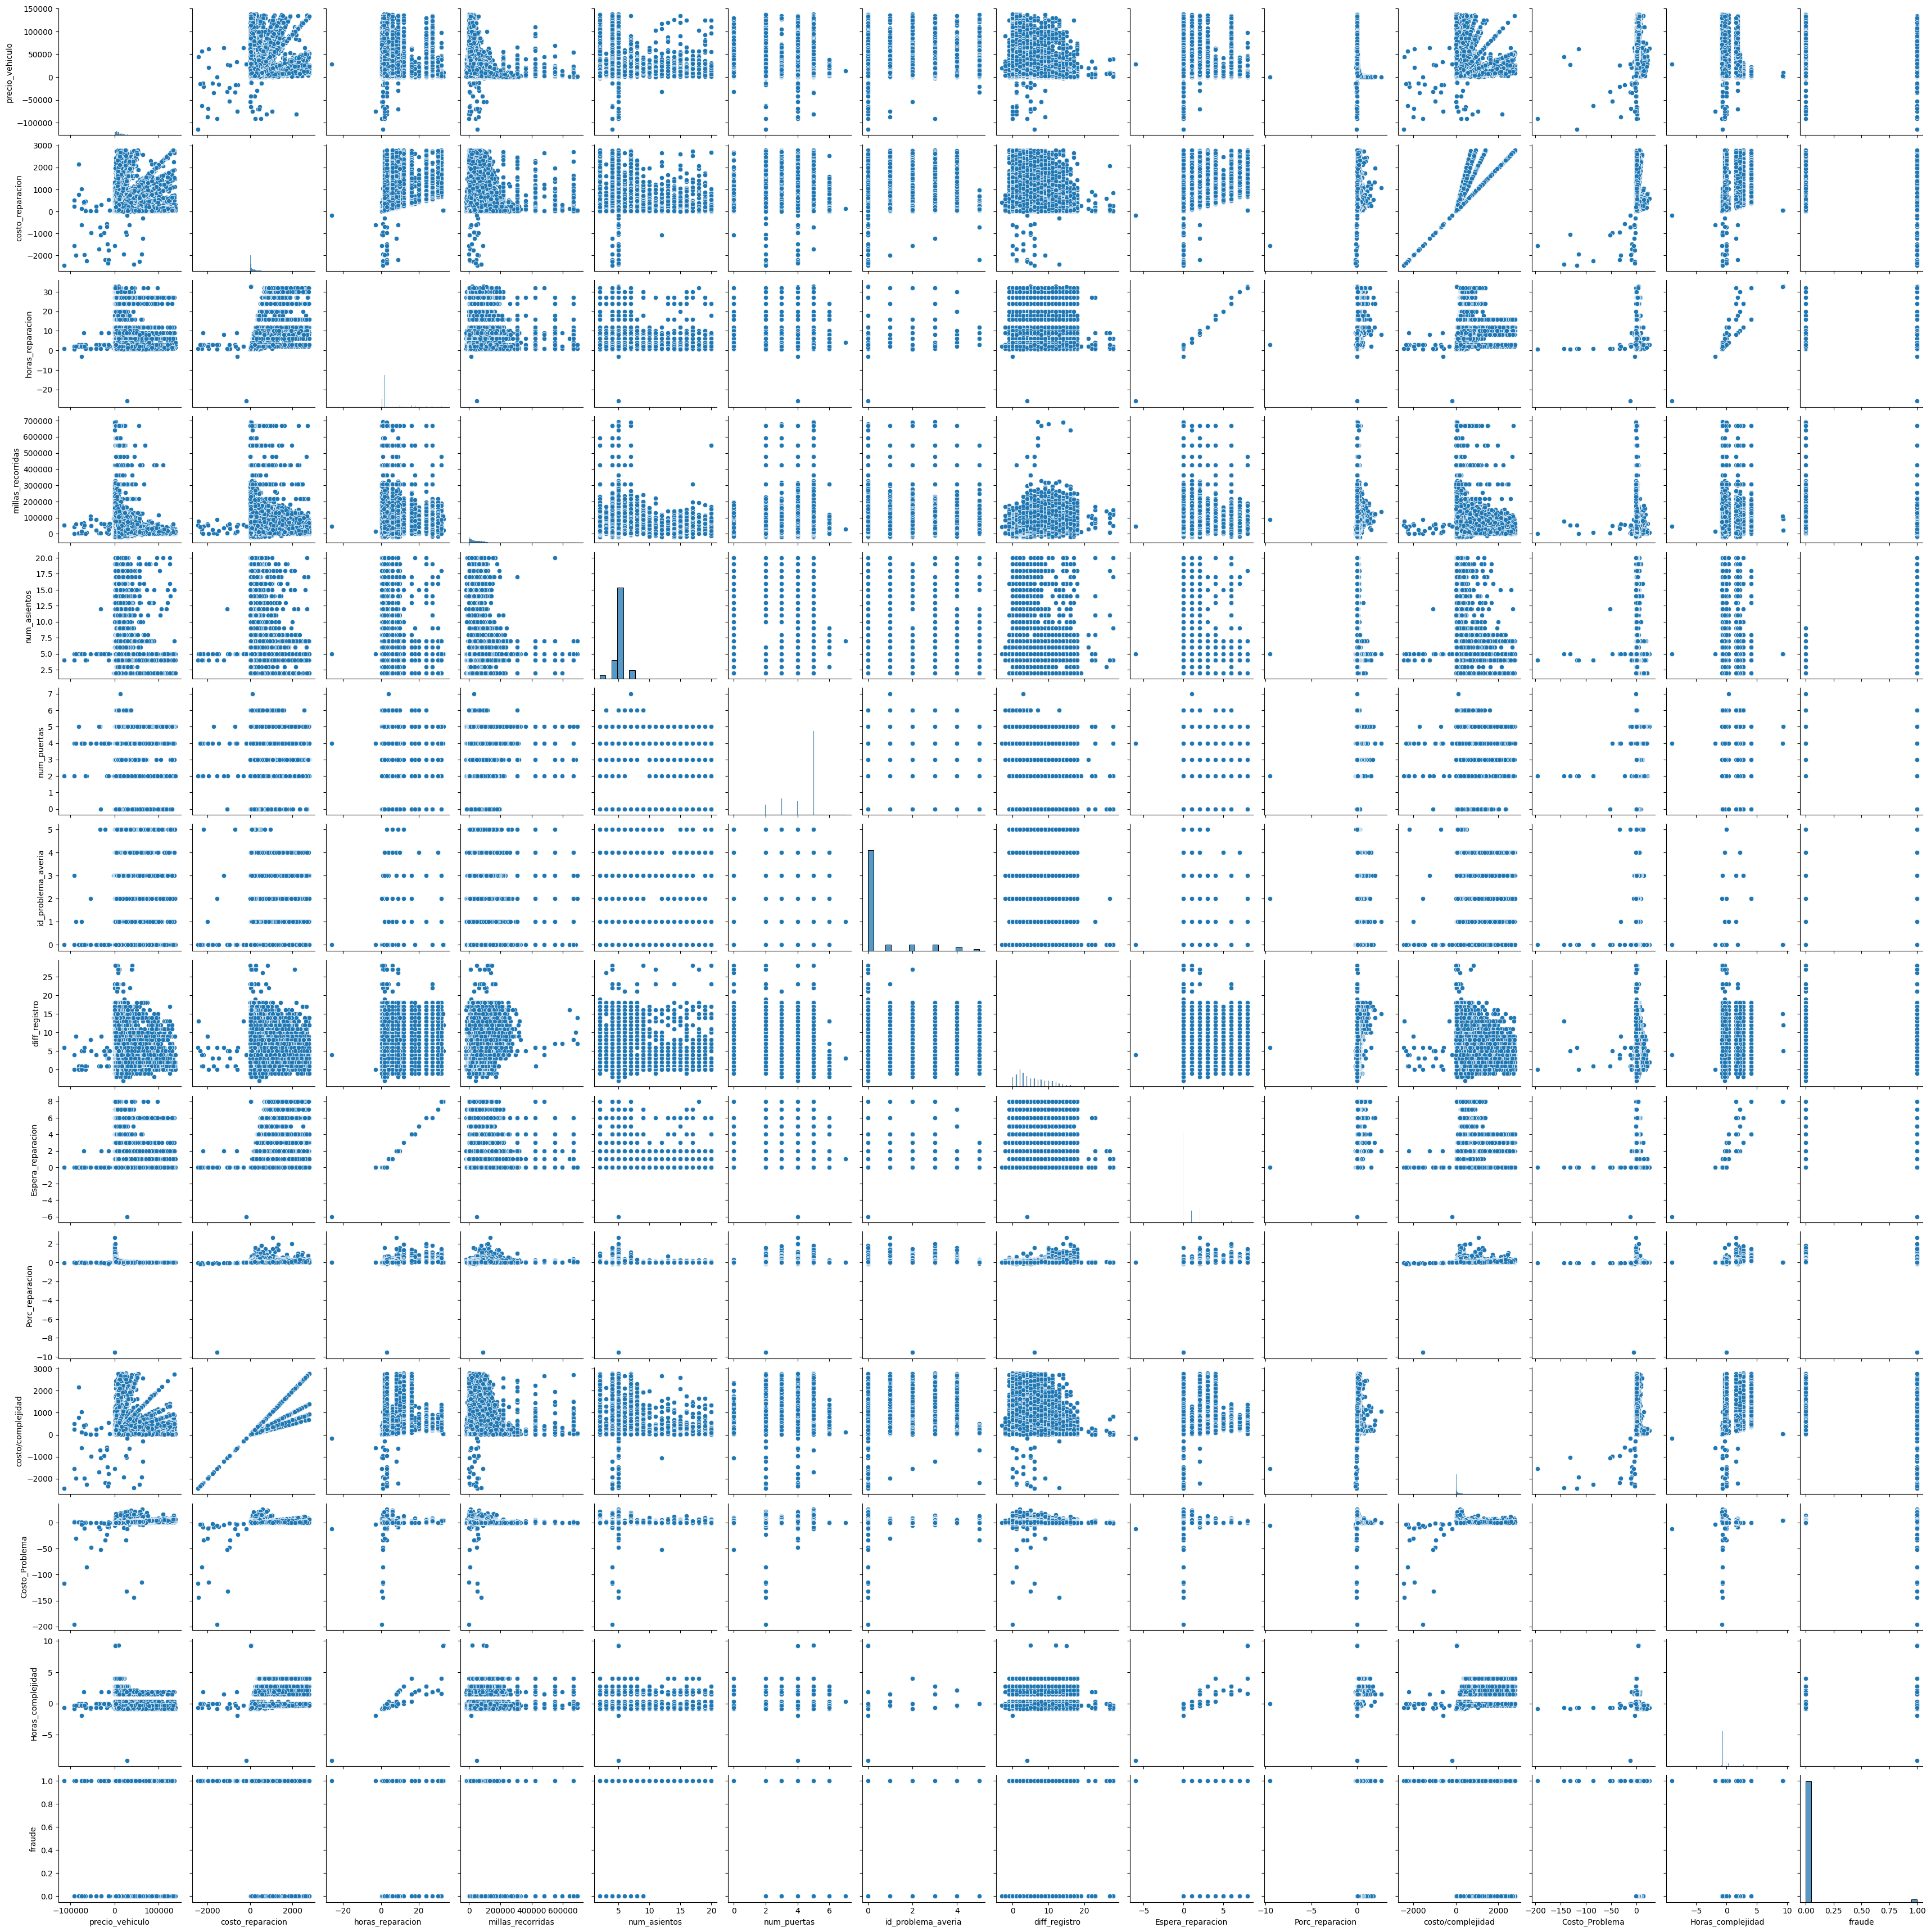

In [34]:
sns.pairplot(df_filtered)

In [35]:
numeric_df = df_filtered.select_dtypes(include=['float64', 'int64'])

In [36]:
corr_matrix = numeric_df.corr()
corr_matrix

precio_vehiculo  costo_reparacion  horas_reparacion  \
precio_vehiculo            1.000000          0.285601          0.074203   
costo_reparacion           0.285601          1.000000          0.569775   
horas_reparacion           0.074203          0.569775          1.000000   
millas_recorridas         -0.388764         -0.131924          0.023225   
num_asientos              -0.020669          0.000172         -0.011414   
num_puertas               -0.072788         -0.012559         -0.033642   
id_problema_averia        -0.024086          0.206792          0.322823   
diff_registro             -0.482951         -0.174952          0.037145   
Porc_reparacion           -0.187534          0.447987          0.500841   
costo/complejidad          0.174156          0.915945          0.399914   
Costo_Problema             0.507647          0.224744          0.138869   
Horas_complejidad         -0.050743          0.573611          0.818027   
fraude                     0.015629          0.047013         -0.010637   

                    millas_recorridas  num_asientos  num_puertas  \
precio_vehiculo             -0.388764     -0.020669    -0.072788   
costo_reparacion            -0.131924      0.000172    -0.012559   
horas_reparacion             0.023225     -0.011414    -0.033642   
millas_recorridas            1.000000      0.029113    -0.028411   
num_asientos                 0.029113      1.000000     0.408908   
num_puertas                 -0.028411      0.408908     1.000000   
id_problema_averia           0.007781     -0.001145     0.001442   
diff_registro                0.621239     -0.067814    -0.177883   
Porc_reparacion              0.172215     -0.010644    -0.021141   
costo/complejidad           -0.129579      0.013466     0.018249   
Costo_Problema              -0.145423     -0.011671    -0.051573   
Horas_complejidad            0.015491     -0.000901     0.005670   
fraude                      -0.018044      0.209247    -0.057021   

                    id_problema_averia  diff_registro  Porc_reparacion  \
precio_vehiculo              -0.024086      -0.482951        -0.187534   
costo_reparacion              0.206792      -0.174952         0.447987   
horas_reparacion              0.322823       0.037145         0.500841   
millas_recorridas             0.007781       0.621239         0.172215   
num_asientos                 -0.001145      -0.067814        -0.010644   
num_puertas                   0.001442      -0.177883        -0.021141   
id_problema_averia            1.000000       0.012221         0.220326   
diff_registro                 0.012221       1.000000         0.258763   
Porc_reparacion               0.220326       0.258763         1.000000   
costo/complejidad             0.217538      -0.180541         0.443477   
Costo_Problema               -0.002073      -0.173082        -0.042437   
Horas_complejidad             0.401784       0.018813         0.570850   
fraude                       -0.001109      -0.010597         0.040470   

                    costo/complejidad  Costo_Problema  Horas_complejidad  \
precio_vehiculo              0.174156        0.507647          -0.050743   
costo_reparacion             0.915945        0.224744           0.573611   
horas_reparacion             0.399914        0.138869           0.818027   
millas_recorridas           -0.129579       -0.145423           0.015491   
num_asientos                 0.013466       -0.011671          -0.000901   
num_puertas                  0.018249       -0.051573           0.005670   
id_problema_averia           0.217538       -0.002073           0.401784   
diff_registro               -0.180541       -0.173082           0.018813   
Porc_reparacion              0.443477       -0.042437           0.570850   
costo/complejidad            1.000000        0.126535           0.583119   
Costo_Problema               0.126535        1.000000          -0.025664   
Horas_complejidad            0.583119       -0.025664           1.0

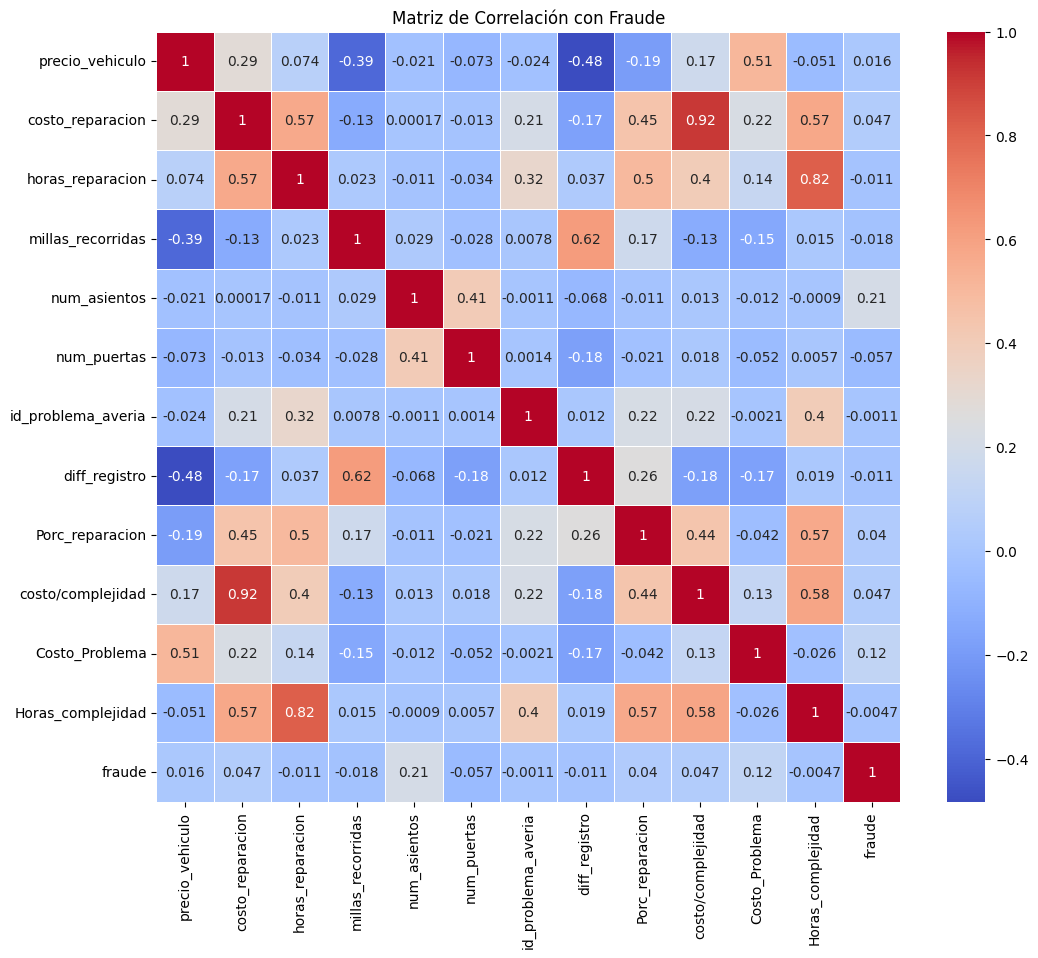

fraude                1.000000
num_asientos          0.209247
Costo_Problema        0.116730
costo/complejidad     0.047492
costo_reparacion      0.047013
Porc_reparacion       0.040470
precio_vehiculo       0.015629
id_problema_averia   -0.001109
Horas_complejidad    -0.004676
diff_registro        -0.010597
horas_reparacion     -0.010637
millas_recorridas    -0.018044
num_puertas          -0.057021
Name: fraude, dtype: float64


In [37]:
df_filtered['fraude'] = df_filtered['fraude'].astype(int)

# Matriz de correlación
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación con Fraude')
plt.show()

# Correlación específica con Fraude
corr_with_fraude = corr_matrix['fraude'].sort_values(ascending=False)
print(corr_with_fraude)

La matriz de correlación nos muestra un poco lo que se observa en cuanto a las correlaciones que existen entre las variables de ellas cabe destacar que existe un:
*   0.98 entre espera_reparacion y horas_reparacion
*   0.92 entre costo/complejidad y costo_reparacion
*   0.82 entre horas_complejidad y horas_repacion y espera_reparacion

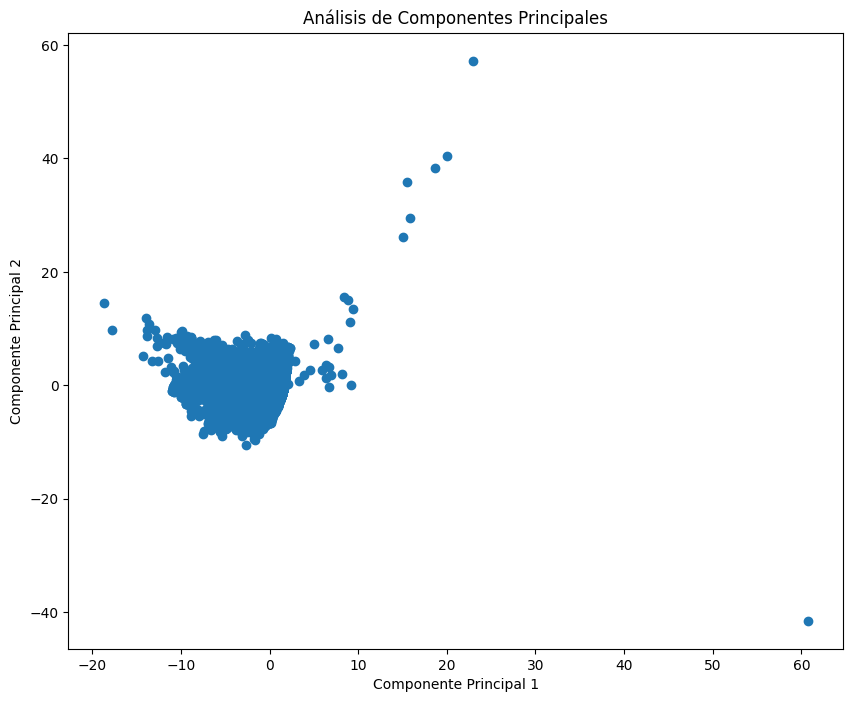

In [38]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Realizar PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Crear un DataFrame con los componentes principales
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Visualización de los componentes principales
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Análisis de Componentes Principales')
plt.show()


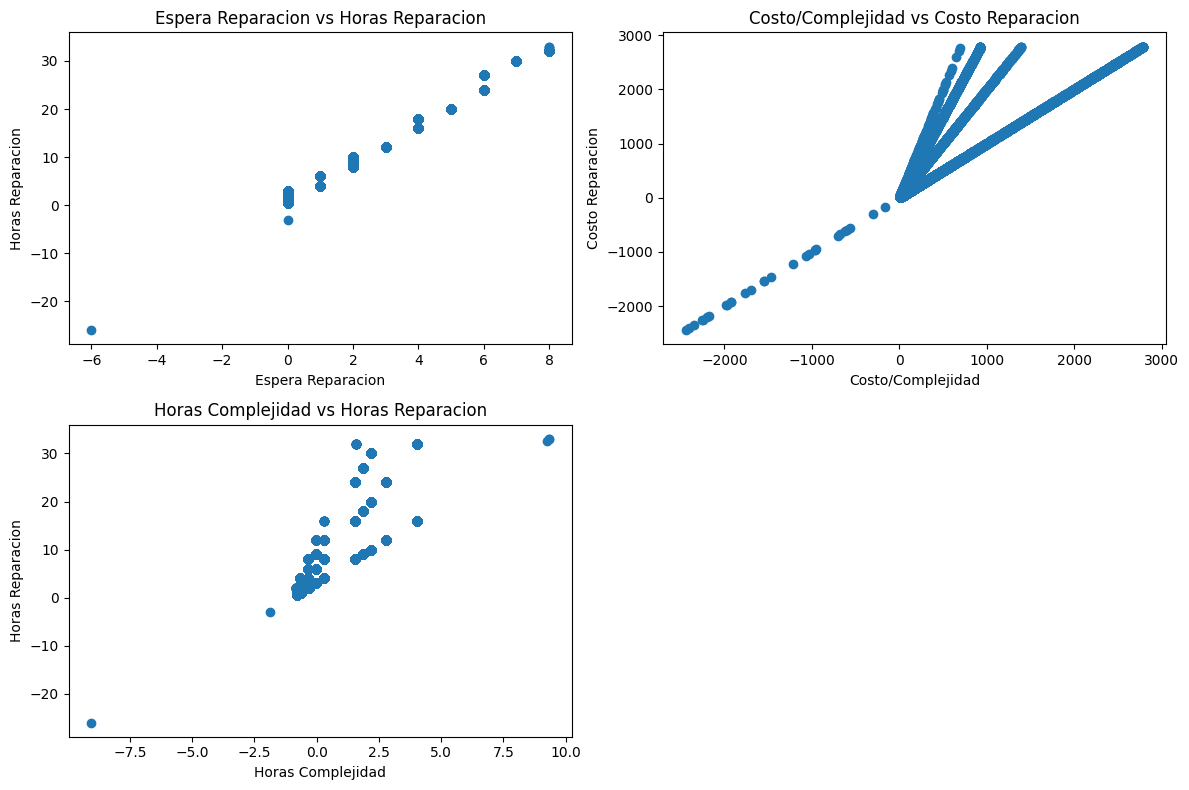

In [39]:
# Scatter plot entre Espera_reparacion y horas_reparacion
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.scatter(df_filtered['Espera_reparacion'], df_filtered['horas_reparacion'])
plt.title('Espera Reparacion vs Horas Reparacion')
plt.xlabel('Espera Reparacion')
plt.ylabel('Horas Reparacion')

# Scatter plot entre costo/complejidad y costo_reparacion
plt.subplot(2, 2, 2)
plt.scatter(df_filtered['costo/complejidad'], df_filtered['costo_reparacion'])
plt.title('Costo/Complejidad vs Costo Reparacion')
plt.xlabel('Costo/Complejidad')
plt.ylabel('Costo Reparacion')

# Scatter plot entre horas_complejidad y horas_repacion
plt.subplot(2, 2, 3)
plt.scatter(df_filtered['Horas_complejidad'], df_filtered['horas_reparacion'])
plt.title('Horas Complejidad vs Horas Reparacion')
plt.xlabel('Horas Complejidad')
plt.ylabel('Horas Reparacion')

plt.tight_layout()
plt.show()

Se aprecian las relaciones entre los graficos. Todos tienen una tendencia a aumentar, donde la mejor ditribucion de la presenta horas de reparacion vs espera. Mientras que los otros graficos sigien una tendencia lineal y de ahi se abren.

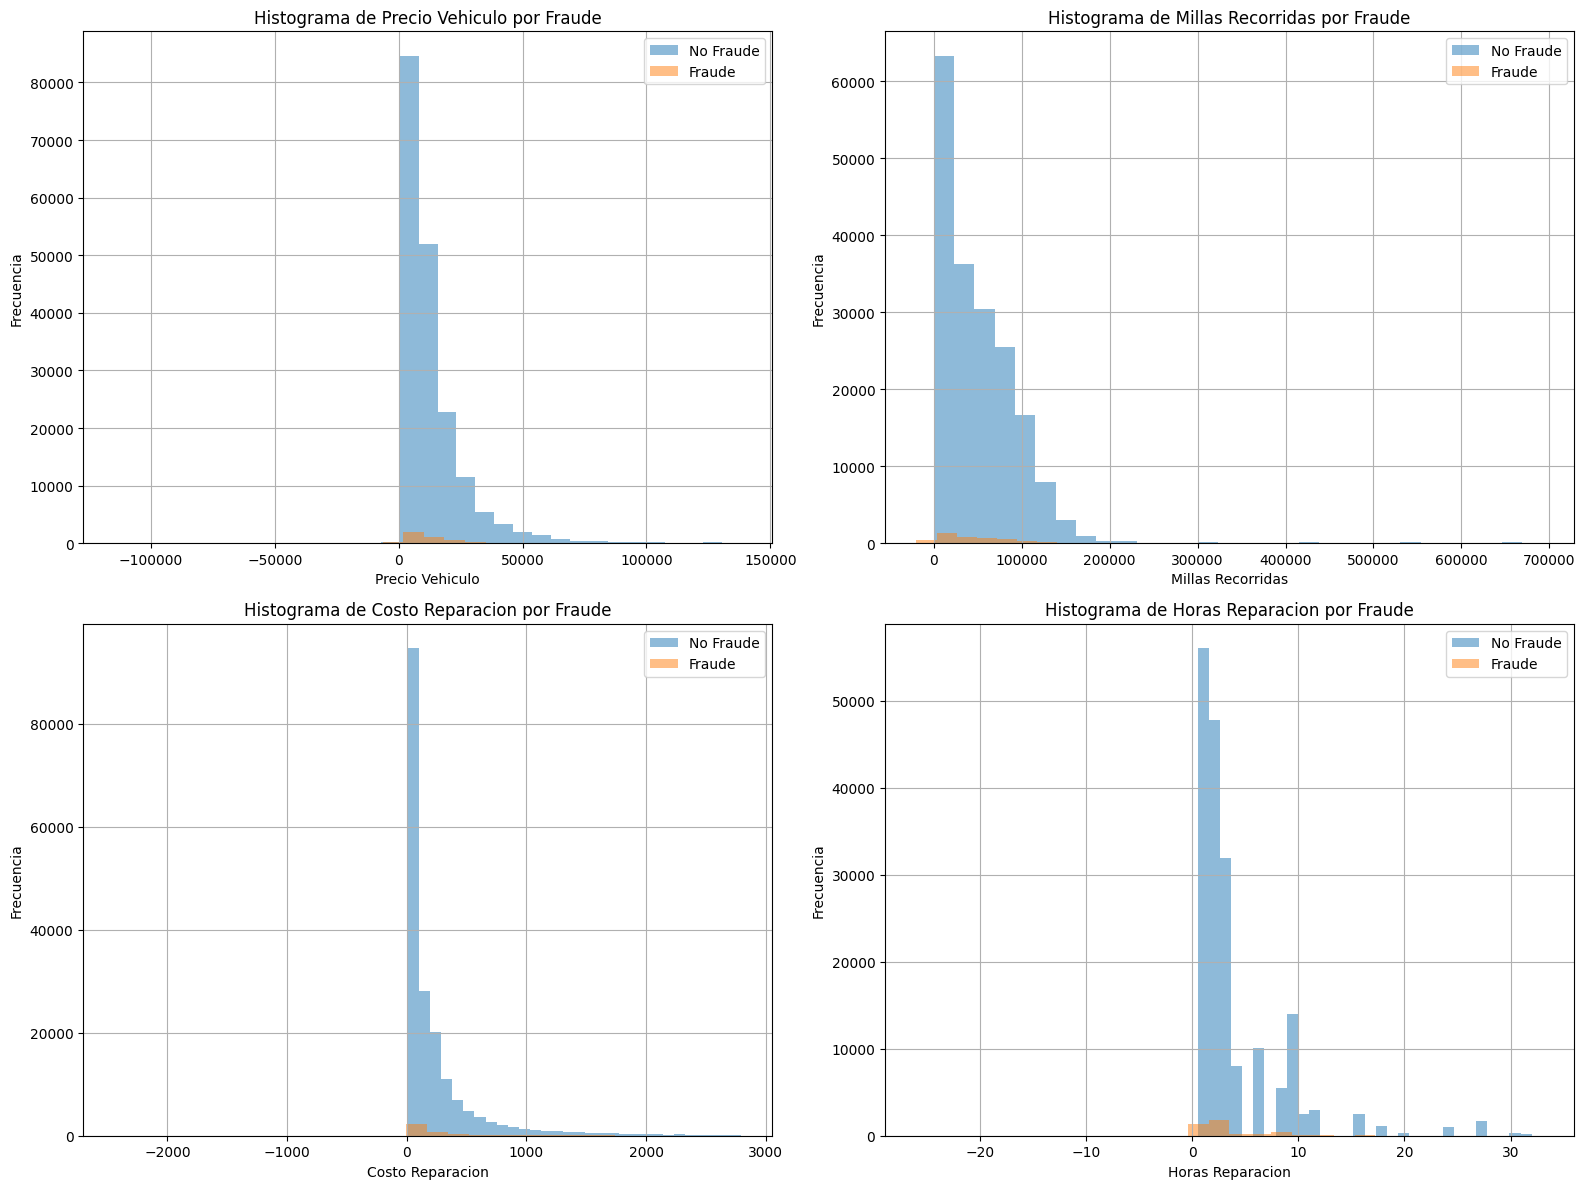

In [40]:
plt.figure(figsize=(16, 12))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    df_filtered[df_filtered['fraude'] == 0][column].hist(alpha=0.5, label='No Fraude', bins=30)
    df_filtered[df_filtered['fraude'] == 1][column].hist(alpha=0.5, label='Fraude', bins=30)
    plt.title(f'Histograma de {column.replace("_", " ").title()} por Fraude')
    plt.xlabel(column.replace("_", " ").title())
    plt.ylabel('Frecuencia')
    plt.legend()

plt.tight_layout()
plt.show()

En la siguiente representacion se puede observar el indice de fraude por variable. En ellos destaca las horas por repacion donde aparentemente se puede visualizar que existe mayor numero de fraude en valores pequeños

# Creación del Modelo

## One-hot encoding + Smote

Se realizaron transformaciones de variables categóricas usando one-hot encoding para las características como transmision y problema_averia. Esto permite que los modelos de machine learning interpreten estas variables correctamente.

In [41]:
target_encoder = ce.TargetEncoder(cols=['color'], smoothing=1)
# Transformación de la columna
df_filtered['color_target_encoded'] = target_encoder.fit_transform(df_filtered['color'], df_filtered['fraude'])
mapping_color = df_filtered[["color","color_target_encoded"]].drop_duplicates().sort_values(by="color_target_encoded", ascending=False).reset_index(drop=True)
### Añadir los numeros de asientos/tamaño de motor
df_filtered = df_filtered[["color_target_encoded",'tipo_vehiculo', 'tipo_combustible', "transmision",'millas_recorridas',"num_asientos","num_puertas",'id_problema_averia','diff_registro', 'Espera_reparacion', "Porc_reparacion",'costo/complejidad',
       'Costo_Problema', 'Horas_complejidad','fraude']]

In [42]:
encoders = {}
# Codificar las columnas categóricas
for col in df_filtered.select_dtypes(include=['object']).columns:
    encoders[col] = LabelEncoder()
    df_filtered[col] = encoders[col].fit_transform(df_filtered[col])

C:\Users\Gis03\AppData\Local\Temp\ipykernel_6356\886776387.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = encoders[col].fit_transform(df_filtered[col])
C:\Users\Gis03\AppData\Local\Temp\ipykernel_6356\886776387.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = encoders[col].fit_transform(df_filtered[col])
C:\Users\Gis03\AppData\Local\Temp\ipykernel_6356\886776387.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [43]:
encoders

{'tipo_vehiculo': LabelEncoder(),
 'tipo_combustible': LabelEncoder(),
 'transmision': LabelEncoder()}

In [44]:
train_data_encoded = df_filtered

In [45]:
X = train_data_encoded.drop('fraude', axis=1)
y = train_data_encoded['fraude']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [46]:
# Se escalan las columnas numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [47]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

In [48]:
print(y_train.value_counts(normalize=True))

fraude
0    0.977257
1    0.022743
Name: proportion, dtype: float64


El hecho de que la clase "fraude" represente solo el 3.12% de los datos sugiere que el conjunto de datos está significativamente desbalanceado. Por lo que se hara ajuste de pesos.

In [49]:
smote = SMOTE(random_state=42)
X_train_scaled_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

## Random Forest

In [50]:
# Entrenar el modelo
model_RF = RandomForestClassifier(random_state=42, class_weight= class_weights_dict)
model_RF.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight={0: 0.5116360502074018,
                                     1: 21.984953703703702},
                       random_state=42)

In [51]:
y_val_pred_RF = model_RF.predict(X_val_scaled)
print('Balanced accuracy score:', balanced_accuracy_score(y_val, y_val_pred_RF))

Balanced accuracy score: 0.9699074074074074


## XGBoost

In [52]:
model_XGB = XGBClassifier(random_state=42,scale_pos_weight=ratio)
model_XGB.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [53]:
scores_xgb = cross_val_score(model_XGB, X_train_scaled, y_train , cv=5)
print('Cross-validated balanced accuracy scores:', scores_xgb)
print('Mean balanced accuracy:', scores_xgb.mean())

Cross-validated balanced accuracy scores: [0.99884838 0.99924322 0.99894709 0.9990129  0.99874967]
Mean balanced accuracy: 0.9989602526980785


In [54]:
print(classification_report(y_val, model_XGB.predict(X_val_scaled)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37127
           1       0.98      0.98      0.98       864

    accuracy                           1.00     37991
   macro avg       0.99      0.99      0.99     37991
weighted avg       1.00      1.00      1.00     37991



In [55]:
y_val_pred_XGB = model_XGB.predict(X_val_scaled)
print('Balanced accuracy score:', balanced_accuracy_score(y_val, y_val_pred_XGB))

Balanced accuracy score: 0.9893678567260125


In [56]:
model_XGB.feature_importances_

array([0.34102634, 0.02697509, 0.06972886, 0.06412188, 0.02062564,
       0.18250328, 0.0971043 , 0.00879612, 0.00617265, 0.03687708,
       0.02913295, 0.02304014, 0.08153822, 0.01235734], dtype=float32)

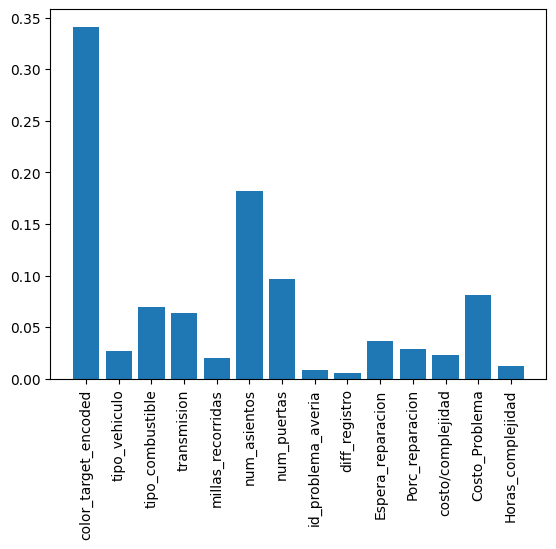

In [57]:
plt.bar(X_train.columns, model_XGB.feature_importances_)
plt.xticks(rotation=90)
plt.show()

## Naive Bayes

In [58]:
model_NB = GaussianNB()
model_NB.fit(X_train_scaled, y_train)

GaussianNB()

In [59]:
y_val_pred_NB = model_NB.predict(X_val_scaled)
print('Balanced accuracy score:', balanced_accuracy_score(y_val, y_val_pred_NB))

Balanced accuracy score: 0.8623581133925695


## Regresión Logística

In [60]:
model_LR = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
model_LR.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [61]:
y_val_pred_RL = model_NB.predict(X_val_scaled)
print('Balanced accuracy score:', balanced_accuracy_score(y_val, y_val_pred_RL))

Balanced accuracy score: 0.8623581133925695


## Optimizacion de hiperparametros

In [62]:
param_distributions = {
    'learning_rate': np.logspace(-3, 0, 4),
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_XGB,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Ejecutar búsqueda aleatoria
random_search.fit(X_train_scaled, y_train)

# Obtener el mejor modelo y parámetros
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Mejores parámetros encontrados:")
print(best_params)

print("Mejor puntuación (AUC):")
print(random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores parámetros encontrados:
{'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}
Mejor puntuación (AUC):
0.9967321685035678


In [63]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [64]:
y_val_pred_HXGB = best_model.predict(X_val_scaled)
print('Balanced accuracy score:', balanced_accuracy_score(y_val, y_val_pred_HXGB))

Balanced accuracy score: 0.9905791332852502


# Predicción sobre nuevos datos

Para la data de test, se debe aplicar el mismo pre-procesamiento de datos que se aplicó a la data de entrenamiento

In [65]:
test_data = pd.read_csv('input/vehiculos_test.csv', parse_dates=['fecha_averia','fecha_reparacion'])

In [66]:
frequent_models = df.groupby('marca')['modelo'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
model_mapping = frequent_models.to_dict()
test_data['modelo'].fillna(test_data['marca'].map(model_mapping), inplace=True)

# Imputación del año de registro
anio_mode_by_brand_model = df.groupby(['marca', 'modelo','tipo_vehiculo'])['anio_registro'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
anio_mode_mapping = anio_mode_by_brand_model.to_dict()

def impute_anio_registro(row):
    if pd.isnull(row['anio_registro']):
        key = (row['marca'], row['modelo'], row['tipo_vehiculo'])
        return anio_mode_mapping.get(key)
    else:
        return row['anio_registro']

test_data['anio_registro'] = test_data.apply(impute_anio_registro, axis=1)

# Imputación de millas recorridas
mean_miles_by_year = df.groupby('anio_registro')['millas_recorridas'].mean()
mean_miles_mapping = mean_miles_by_year.to_dict()

def impute_millas_recorridas(row):
    if pd.isnull(row['millas_recorridas']):
        year_registered = row['anio_registro']
        repair_year = pd.to_datetime(row['fecha_reparacion']).year
        mean_miles = mean_miles_mapping.get(year_registered, df['millas_recorridas'].mean())
        if np.isnan(mean_miles):
            return -1
        else:
            return mean_miles * (repair_year - year_registered + 1)
    else:
        return row['millas_recorridas']

test_data['millas_recorridas'] = test_data.apply(impute_millas_recorridas, axis=1)

# Imputación del precio del vehículo
mean_price_by_model_brand = df.groupby(['marca', 'modelo', 'tipo_vehiculo', 'anio_registro'])['precio_vehiculo'].mean()
mean_price_mapping = mean_price_by_model_brand.to_dict()

def impute_precio_vehiculo(row):
    if pd.isnull(row['precio_vehiculo']):
        brand = row['marca']
        model = row['modelo']
        mean_price = mean_price_mapping.get((brand, model, row['tipo_vehiculo'], row['anio_registro']), df['precio_vehiculo'].mean())
        return mean_price
    else:
        return row['precio_vehiculo']

test_data['precio_vehiculo'] = test_data.apply(impute_precio_vehiculo, axis=1)

# Imputación del tamaño del motor
motor_size_mode_by_brand_model_type = df.groupby(['marca', 'modelo', 'tipo_vehiculo'])['tamanio_motor'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
motor_size_mode_mapping = motor_size_mode_by_brand_model_type.to_dict()

def impute_tamanio_motor(row):
    if pd.isnull(row['tamanio_motor']):
        brand = row['marca']
        model = row['modelo']
        mode_motor_size = motor_size_mode_mapping.get((brand, model, row['tipo_vehiculo']))
        return mode_motor_size
    else:
        return row['tamanio_motor']

test_data['tamanio_motor'] = test_data.apply(impute_tamanio_motor, axis=1)

# Imputación del color
test_data["color"].fillna(test_data["color"].mode()[0], inplace=True)


# revisamos diferencias en fehcas de averia y reparacion con respecto al registro
test_data["diff_registro"] = test_data["fecha_averia"].dt.year - test_data["anio_registro"]
test_data["Espera_reparacion"] = (test_data["fecha_reparacion"] - test_data["fecha_averia"]).dt.days
test_data["Espera_reparacion"] = test_data["Espera_reparacion"].astype(int)
test_data["diff_registro"] = test_data["diff_registro"].fillna(0)
test_data["costo/complejidad"] = test_data["costo_reparacion"] / test_data["complejidad_reparacion"]
test_data = calcular_costo_rep(test_data,df_no_fraude_problema)
test_data = calcular_complejidad_hora(test_data,df_horas_complejo)
test_data["Porc_reparacion"] = test_data["costo_reparacion"]/ test_data["precio_vehiculo"].abs()
test_data["Porc_reparacion"] = test_data["Porc_reparacion"].fillna(df["Porc_reparacion"].mean())
### Imputar millas recorridas con el promedio de las millas (pensar en otra idea porque no me gusta)
test_data["millas_recorridas"] = test_data["millas_recorridas"].fillna(df["millas_recorridas"].mean())
test_data = getFraudeByAS(test_data,asientos_max)
### Añadir los numeros de asientos/tamaño de motor
test_data_cleaned = test_data[["color",'tipo_vehiculo', 'tipo_combustible', "transmision",'millas_recorridas',"num_asientos","num_puertas",'id_problema_averia','diff_registro', 'Espera_reparacion', "Porc_reparacion",'costo/complejidad',
       'Costo_Problema', 'Horas_complejidad']]


C:\Users\Gis03\AppData\Local\Temp\ipykernel_6356\3743801917.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['modelo'].fillna(test_data['marca'].map(model_mapping), inplace=True)
C:\Users\Gis03\AppData\Local\Temp\ipykernel_6356\3743801917.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [67]:
### Se revisar las variables categoricas con los encoders generados previamente
columna_colores = test_data_cleaned["color"]
columna_vehiculo = test_data_cleaned["tipo_vehiculo"]
columna_combustible = test_data_cleaned["tipo_combustible"]
columna_transmision = test_data_cleaned["transmision"]
test_data_cleaned =test_data_cleaned.merge(mapping_color, on="color", how="left")
# encoding del tipo de vehiculo, tipo de combustible y transmision
test_data_cleaned["tipo_vehiculo"] = encoders["tipo_vehiculo"].transform(test_data_cleaned["tipo_vehiculo"])
test_data_cleaned["tipo_combustible"] = encoders["tipo_combustible"].transform(test_data_cleaned["tipo_combustible"])
test_data_cleaned["transmision"] = encoders["transmision"].transform(test_data_cleaned["transmision"])
test_data_cleaned = test_data_cleaned[["color_target_encoded",'tipo_vehiculo', 'tipo_combustible', "transmision",'millas_recorridas',"num_asientos","num_puertas",'id_problema_averia','diff_registro', 'Espera_reparacion', "Porc_reparacion",'costo/complejidad',
       'Costo_Problema', 'Horas_complejidad']]

In [68]:
df_test_scaled = scaler.transform(test_data_cleaned)
df_test_scaled = pd.DataFrame(df_test_scaled, columns=test_data_cleaned.columns)
df_test_pred = best_model.predict(df_test_scaled)

In [69]:
test_data_cleaned["color"] = columna_colores
test_data_cleaned["fraude"] = df_test_pred

In [70]:
test_data_cleaned

color_target_encoded  tipo_vehiculo  tipo_combustible  transmision  \
0                  0.010131             13                 1            0   
1                  0.012509             13                 1            0   
2                  0.010131             13                 1            0   
3                  0.012203             13                 1            0   
4                  0.009670             13                 1            0   
...                     ...            ...               ...          ...   
21821              0.012509              7                10            0   
21822              0.012509              7                10            0   
21823              0.010131              7                10            0   
21824              0.012509              7                10            0   
21825              0.012509              7                10            0   

       millas_recorridas  num_asientos  num_puertas  id_problema_averia  \
0                37723.0           5.0          4.0                   0   
1               106700.0           5.0          4.0                   0   
2                 3541.0           5.0          4.0                   0   
3                34750.0           4.0          4.0                   0   
4                17264.0           5.0          4.0                   0   
...                  ...           ...          ...                 ...   
21821             7000.0           5.0          4.0                   0   
21822            26000.0           5.0          4.0                   2   
21823             5200.0           5.0          4.0                   0   
21824            30300.0           5.0          4.0                   0   
21825            29000.0           5.0          4.0                   0   

       diff_registro  Espera_reparacion  Porc_reparacion  costo/complejidad  \
0                3.0                  0         0.001876          23.807000   
1                5.0                  0         0.001729          24.198200   
2                0.0                  0         0.006677         152.768924   
3                6.0                  0         0.001381          25.550000   
4                2.0                  0         0.000967          29.000000   
...              ...                ...              ...                ...   
21821            4.0                  0         0.001316          83.331667   
21822           13.0                  0         0.002334          69.966667   
21823           13.0                  6         0.015687         496.500000   
21824           12.0                  1         0.011263         356.666667   
21825            6.0                  2         0.011029         643.166667   

       Costo_Problema  Horas_complejidad   color  fraude  
0           -0.440997          -0.638442    Blue       0  
1           -0.418014          -0.638442   White       0  
2            7.135355          -0.638442  Orange       1  
3           -0.338598          -0.638442   Black       0  
4           -0.135914          -0.638442   Black       0  
...               ...                ...     ...     ...  
21821        7.035639          -0.644171    Grey       0  
21822        1.937568          -0.800631   White       0  
21823        3.950325           1.859188    Blue       0  
21824        4.247214          -0.331251  Silver       0  
21825        8.077139          -0.018331    Grey       0  

[21826 rows x 16 columns]

In [71]:
test_predictions = pd.DataFrame({'id': test_data_cleaned.index, 'fraude_pred': df_test_pred})

In [72]:
test_predictions.fraude_pred.value_counts()

fraude_pred
0    21143
1      683
Name: count, dtype: int64

In [73]:
test_predictions.to_csv('result_test.csv', index=False)

# Shaps

In [74]:
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_val)

100%|===================| 37949/37991 [05:34<00:00]        

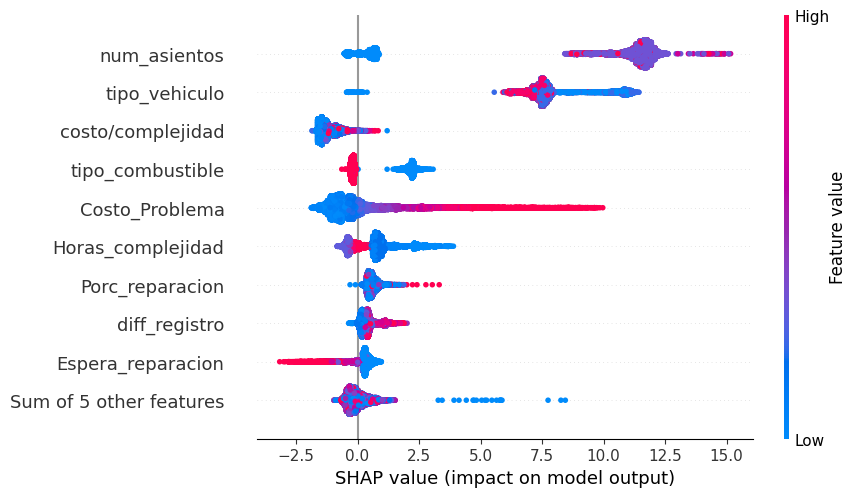

In [75]:
shap.initjs()
shap.plots.beeswarm(shap_values)

## Revisar Casos particulares de fraude

In [76]:
df_test_scaled['fraude'] = df_test_pred
df_test_scaled["color"] = columna_colores
df_test_scaled["vehiculo_original"] = columna_vehiculo
df_test_scaled["combustible_original"] = columna_combustible
df_test_scaled["transmision_original"] = columna_transmision
df_fraud_cases = df_test_scaled.loc[df_test_scaled['fraude']==1]
df_fraud_cases = df_fraud_cases.reset_index(drop=True)
df_fraud_cases.drop(columns=['fraude'],inplace=True)

In [77]:
# Explicación del caso específico
shap_fraude_case = explainer(df_fraud_cases.drop(columns=["color","vehiculo_original","combustible_original","transmision_original"]))

In [ ]:
Caso_analizar = 1

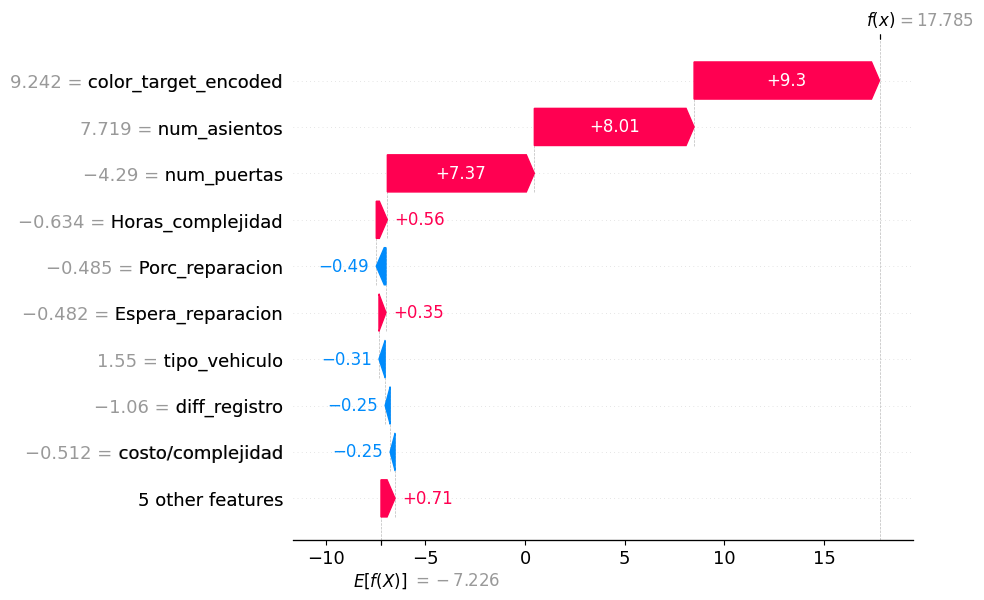

In [78]:
shap.initjs()
shap.plots.waterfall(shap_fraude_case[Caso_analizar])

In [79]:
df_fraud_cases.loc[[Caso_analizar],:]

color_target_encoded  tipo_vehiculo  tipo_combustible  transmision  \
1              9.242289       1.550321          -1.00632    -1.374314   

   millas_recorridas  num_asientos  num_puertas  id_problema_averia  \
1          -0.847116      7.718502    -4.290033           -0.424847   

   diff_registro  Espera_reparacion  Porc_reparacion  costo/complejidad  \
1      -1.059517          -0.481647        -0.484737          -0.511794   

   Costo_Problema  Horas_complejidad   color vehiculo_original  \
1       -0.120949          -0.633895  Silver         Hatchback   

  combustible_original transmision_original  
1               Petrol               Manual

## Revisar Casos particulares de no fraude

In [80]:
df_no_fraud_cases = df_test_scaled.loc[df_test_scaled['fraude']==0]
df_no_fraud_cases = df_no_fraud_cases.reset_index(drop=True)
df_no_fraud_cases.drop(columns=['fraude'],inplace=True)

In [81]:
# Explicación del caso específico
shap_no_fraude_case = explainer(df_no_fraud_cases.drop(columns=["color","vehiculo_original","combustible_original","transmision_original"]))

 99%|===================| 21008/21143 [02:25<00:00]        

In [ ]:
No_fraude_analizar = 1

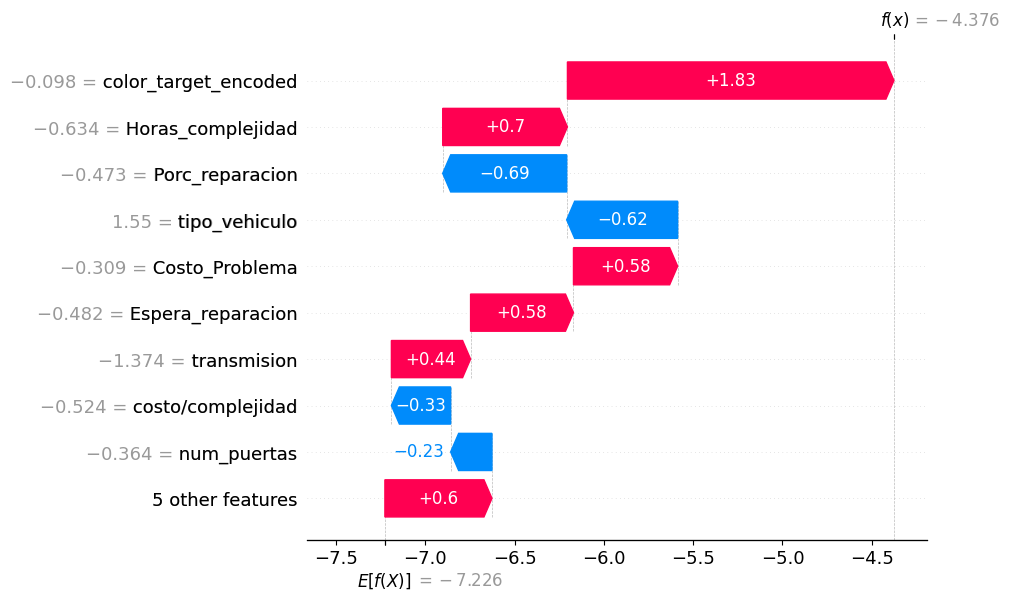

In [82]:
shap.initjs()
shap.plots.waterfall(shap_no_fraude_case[No_fraude_analizar])

In [83]:
df_no_fraud_cases.loc[[Caso_analizar],:]

color_target_encoded  tipo_vehiculo  tipo_combustible  transmision  \
1             -0.098046       1.550321          -1.00632    -1.374314   

   millas_recorridas  num_asientos  num_puertas  id_problema_averia  \
1           1.160014      0.054695    -0.363831           -0.424847   

   diff_registro  Espera_reparacion  Porc_reparacion  costo/complejidad  \
1      -0.112447          -0.481647        -0.473157          -0.523971   

   Costo_Problema  Horas_complejidad  color vehiculo_original  \
1       -0.308679          -0.633895  White            Saloon   

  combustible_original transmision_original  
1               Diesel            Automatic